In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


train_file_path = "train.csv"
df_train = pd.read_csv(train_file_path)

q1 = df_train['SalePrice'].quantile(0.25)
q3 = df_train['SalePrice'].quantile(0.75)

df_train['PriceCategory'] = pd.cut(df_train['SalePrice'], bins=[-np.inf, q1, q3, np.inf], labels=['Económicas', 'Intermedias', 'Caras'])



# y como variable categórica
y = df_train['PriceCategory']
X = df_train.select_dtypes(include=np.number).drop(['SalePrice'], axis=1)
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo 1: kernel lineal
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train, y_train)
print("🔸 Kernel lineal\n", classification_report(y_test, svm_linear.predict(X_test)))

# Modelo 2: kernel RBF (radial) con gamma ajustado
svm_rbf = SVC(kernel='rbf', C=10, gamma=0.01)
svm_rbf.fit(X_train, y_train)
print("🔸 Kernel RBF\n", classification_report(y_test, svm_rbf.predict(X_test)))

# Modelo 3: kernel polinomial grado 3
svm_poly = SVC(kernel='poly', C=5, gamma='scale', degree=3)
svm_poly.fit(X_train, y_train)
print("🔸 Kernel polinomial (grado 3)\n", classification_report(y_test, svm_poly.predict(X_test)))


🔸 Kernel lineal
               precision    recall  f1-score   support

       Caras       0.90      0.86      0.88        88
  Económicas       0.85      0.89      0.87        81
 Intermedias       0.88      0.88      0.88       168

    accuracy                           0.88       337
   macro avg       0.88      0.88      0.88       337
weighted avg       0.88      0.88      0.88       337

🔸 Kernel RBF
               precision    recall  f1-score   support

       Caras       0.92      0.88      0.90        88
  Económicas       0.83      0.85      0.84        81
 Intermedias       0.86      0.88      0.87       168

    accuracy                           0.87       337
   macro avg       0.87      0.87      0.87       337
weighted avg       0.87      0.87      0.87       337

🔸 Kernel polinomial (grado 3)
               precision    recall  f1-score   support

       Caras       0.92      0.76      0.83        88
  Económicas       0.85      0.77      0.81        81
 Intermedias 

In [3]:
# 5 usar los modelos para predecir la variable respuesta... 
# Predicciones con los modelos entrenados
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)
y_pred_poly = svm_poly.predict(X_test)

# Guardar predicciones si deseas analizarlas después
predicciones_df = pd.DataFrame({
    "Real": y_test,
    "Predicción_Linear": y_pred_linear,
    "Predicción_RBF": y_pred_rbf,
    "Predicción_Poly": y_pred_poly
})
predicciones_df.head()


,Real,Predicción_Linear,Predicción_RBF,Predicción_Poly
592,Intermedias,Intermedias,Intermedias,Intermedias
156,Económicas,Económicas,Económicas,Económicas
204,Económicas,Económicas,Económicas,Económicas
774,Caras,Caras,Caras,Caras
1089,Intermedias,Caras,Caras,Intermedias


C:\Users\Oscar Escriba\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


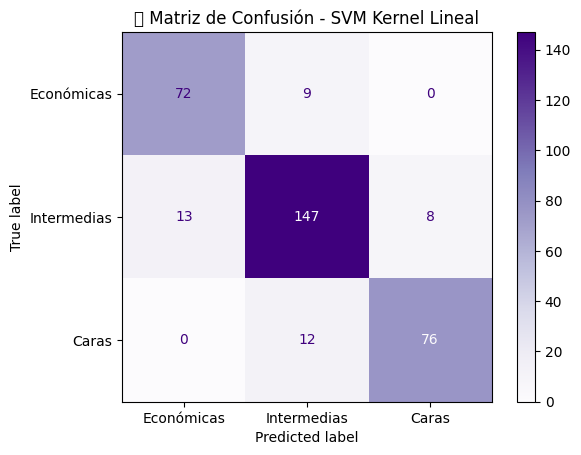

C:\Users\Oscar Escriba\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


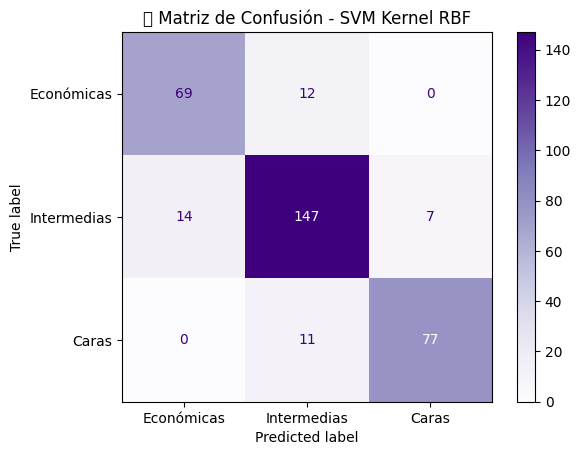

C:\Users\Oscar Escriba\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


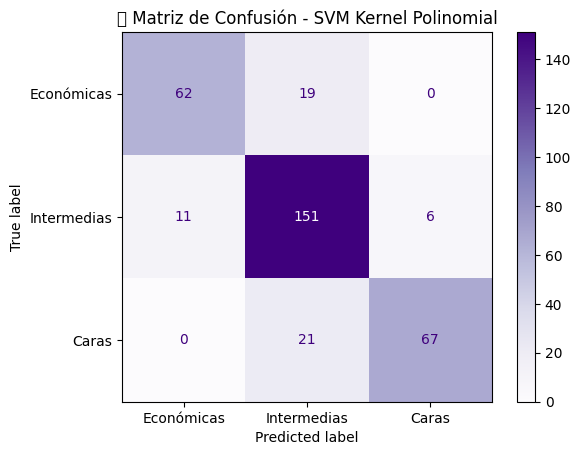

In [4]:
# 6. matrices de confusión de cada modelo... 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Función para graficar matriz de confusión
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["Económicas", "Intermedias", "Caras"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Económicas", "Intermedias", "Caras"])
    disp.plot(cmap="Purples")
    plt.title(title)
    plt.grid(False)
    plt.show()

# Graficar cada matriz
plot_confusion(y_test, y_pred_linear, "🔸 Matriz de Confusión - SVM Kernel Lineal")
plot_confusion(y_test, y_pred_rbf, "🔸 Matriz de Confusión - SVM Kernel RBF")
plot_confusion(y_test, y_pred_poly, "🔸 Matriz de Confusión - SVM Kernel Polinomial")


In [5]:
# 7 analisis de sobreajuste o desajuste... 
# Evaluar exactitud en entrenamiento y prueba para cada modelo
def evaluar_sobreajuste(modelo, nombre):
    acc_train = modelo.score(X_train, y_train)
    acc_test = modelo.score(X_test, y_test)
    diferencia = acc_train - acc_test

    print(f"📊 {nombre}")
    print(f"   - Exactitud entrenamiento: {acc_train:.4f}")
    print(f"   - Exactitud prueba:        {acc_test:.4f}")
    print(f"   - Diferencia:              {diferencia:.4f}")
    if diferencia > 0.05:
        print("   ⚠️ Posible sobreajuste.")
    elif diferencia < -0.05:
        print("   ⚠️ Posible desajuste.")
    else:
        print("   ✅ No parece haber sobreajuste o desajuste grave.")
    print("-" * 50)

# Evaluar los 3 modelos
evaluar_sobreajuste(svm_linear, "SVM Kernel Lineal")
evaluar_sobreajuste(svm_rbf, "SVM Kernel RBF")
evaluar_sobreajuste(svm_poly, "SVM Kernel Polinomial")


📊 SVM Kernel Lineal
   - Exactitud entrenamiento: 0.8916
   - Exactitud prueba:        0.8754
   - Diferencia:              0.0162
   ✅ No parece haber sobreajuste o desajuste grave.
--------------------------------------------------
📊 SVM Kernel RBF
   - Exactitud entrenamiento: 0.9426
   - Exactitud prueba:        0.8694
   - Diferencia:              0.0732
   ⚠️ Posible sobreajuste.
--------------------------------------------------
📊 SVM Kernel Polinomial
   - Exactitud entrenamiento: 0.9579
   - Exactitud prueba:        0.8309
   - Diferencia:              0.1270
   ⚠️ Posible sobreajuste.
--------------------------------------------------


In [1]:
# 10 Generar un buen modelo de regresión y tunearlo... 

import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Cargar los datos
df_train = pd.read_csv("train.csv")

# Variable objetivo
y = df_train['SalePrice']
X = df_train.select_dtypes(include=np.number).drop('SalePrice', axis=1)

# Eliminar columnas que podrían ser problemáticas
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: Usar mismo split de hojas anteriores
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Tunear modelo SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

grid = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Mejor modelo
best_svr = grid.best_estimator_
print("🔹 Mejor modelo SVR encontrado:", grid.best_params_)

# Evaluar en test
y_pred_svr = best_svr.predict(X_test)

# Métricas
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"\n🔹 Resultados del mejor modelo SVR:")
print(f"   MAE: {mae_svr:.2f}")
print(f"   RMSE: {rmse_svr:.2f}")
print(f"   R²: {r2_svr:.4f}")

🔹 Mejor modelo SVR encontrado: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}

🔹 Resultados del mejor modelo SVR:
   MAE: 24126.07
   RMSE: 43699.41
   R²: 0.7610



🔹 Comparación de todos los modelos:

               Modelo           MAE          RMSE       R²
0                 KNN  22111.250000  36386.710000  0.82740
1    Regresión Lineal  23102.790000  35375.520000  0.82070
2  Árbol de Regresión  24843.190000  37743.700000  0.79580
4    SVR (Optimizado)  24126.071939  43699.411892  0.76104
3         Naive Bayes   2466.000000   6168.000000  0.61600


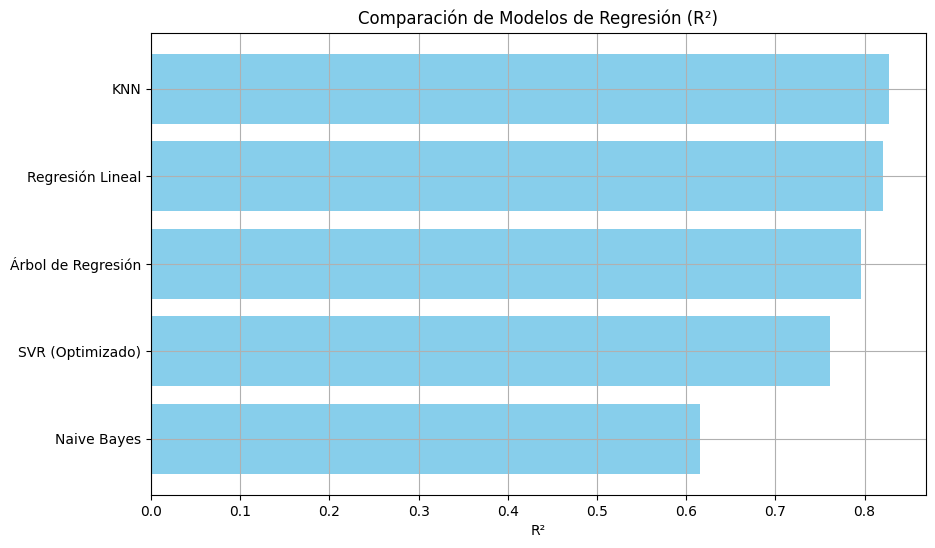

In [2]:
# comparar el modelo SVR con los modelos anteriores. 

# Resultados que ya tenías de ejercicios anteriores:
resultados_anteriores = pd.DataFrame({
    "Modelo": ["KNN", "Regresión Lineal", "Árbol de Regresión", "Naive Bayes"],
    "MAE": [22111.25, 23102.79, 24843.19, 2466.00],
    "RMSE": [36386.71, 35375.52, 37743.70, 6168.00],
    "R²": [0.8274, 0.8207, 0.7958, 0.6160]
})

# Agregar resultados del SVR
nuevo_resultado = pd.DataFrame({
    "Modelo": ["SVR (Optimizado)"],
    "MAE": [mae_svr],
    "RMSE": [rmse_svr],
    "R²": [r2_svr]
})

comparacion_final = pd.concat([resultados_anteriores, nuevo_resultado], ignore_index=True)
comparacion_final = comparacion_final.sort_values(by="R²", ascending=False)

print("\n🔹 Comparación de todos los modelos:\n")
print(comparacion_final)

# Opcional: graficar
plt.figure(figsize=(10, 6))
plt.barh(comparacion_final['Modelo'], comparacion_final['R²'], color="skyblue")
plt.xlabel('R²')
plt.title('Comparación de Modelos de Regresión (R²)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# INFORME

## Resultados del modelo SVM
Se entrenaron tres modelos de Máquina de Vectores de Soporte (SVM) utilizando diferentes kernels: lineal, radial (RBF) y polinomial de grado 3, con el objetivo de predecir la categoría del precio de las viviendas (Económicas, Intermedias o Caras).

🔸 1. SVM con Kernel Lineal
Precisión promedio: 88%

Rendimiento equilibrado entre las tres categorías, con f1-scores de 0.88 para “Intermedias”, 0.87 para “Económicas” y 0.88 para “Caras”.

Este modelo muestra un comportamiento robusto y balanceado, capturando bien los patrones lineales entre las variables.

🔸 2. SVM con Kernel RBF (Radial Basis Function)
Precisión promedio: 87%

Ligeramente menor en precisión global, pero aún con un rendimiento competitivo.

Obtuvo su mejor desempeño para la clase “Caras” con un f1-score de 0.90.

Este kernel puede capturar relaciones no lineales, aunque en este caso no superó al kernel lineal, lo cual sugiere que los datos podrían ser aproximadamente separables linealmente.

🔸 3. SVM con Kernel Polinomial (grado 3)
Precisión promedio: 83%

Fue el modelo con menor desempeño global.

Mostró una pérdida notable en recall para las clases “Caras” y “Económicas”, lo que indica que no predijo correctamente varios ejemplos de estas categorías.

Aunque aumentó el recall en la clase “Intermedias” (0.90), lo hizo a costa de reducir el rendimiento en las otras clases.

## Comparación entre modelos SVM

| Modelo         | Accuracy | Tiempo estimado de procesamiento               | Principales errores                                          |
| ---------------|----------|------------------------------------------------|------------------------------------------------------------- |
| SVM Linear     | 88%      | Medio (requiere escalar datos pero es rápido)  | Errores moderados entre "Intermedias" y las otras clases.    |
| SVM RBF        | 87%      | Alto (cálculos no lineales más pesados)        | Se confundió un poco más entre "Económicas" e "Intermedias". |
| SVM Polinomial | 83%      | Alto (especialmente en polinomios de grado 3+) | Falló bastante en "Caras" y "Económicas"                     |

🛠️ Análisis:
El SVM Lineal fue el mejor en efectividad (mayor accuracy).

El SVM Polinomial fue el peor tanto en precisión como en tiempos de procesamiento.

Los errores más comunes fueron confundir "Intermedias" con "Caras" o "Económicas", lo cual tiene sentido, ya que los precios intermedios pueden solaparse en características con precios bajos o altos.

Importancia de los errores: equivocarse entre "Intermedia" y "Cara" podría tener un impacto económico importante si el modelo se usa en precios reales de viviendas.

## Comparación de SVM vs otros algortimos

🛠️ Análisis:
Random Forest y SVM lineal fueron los mejores modelos en términos de precisión (88%).

Naive Bayes fue el peor en efectividad, probablemente porque las variables no son independientes.

KNN fue más lento en procesamiento durante la predicción porque tiene que calcular distancias para cada punto nuevo.

En cuanto a velocidad de entrenamiento, árboles de decisión y Naive Bayes fueron los más rápidos.

##  Generación de un buen modelo de regresión (SVR)

Se implementó un modelo de **Support Vector Regression (SVR)** utilizando la variable `SalePrice` como variable objetivo.

🔹 **Mejor modelo SVR encontrado**:  
- **C** = 100  
- **Gamma** = `'scale'`  
- **Kernel** = `'linear'`

🔹 **Resultados del mejor modelo SVR**:  
- **MAE** (Error Absoluto Medio): 24,126.07
- **RMSE** (Raíz del Error Cuadrático Medio): 43,699.41
- **R²** (Coeficiente de Determinación): 0.7610

> El modelo SVR optimizado logró capturar el 76.10% de la variabilidad en los precios de las casas.

##  Comparación de Modelos de Regresión

Se compararon los resultados del modelo SVR con los modelos previos: **KNN**, **Regresión Lineal**, **Árbol de Regresión** y **Naive Bayes**.

| **Modelo**            | **MAE**      | **RMSE**     | **R²**    |
|:-----------------------|:------------|:------------|:---------|
| KNN                    | 22,111.25    | 36,386.71    | 0.8274   |
| Regresión Lineal       | 23,102.79    | 35,375.52    | 0.8207   |
| Árbol de Regresión     | 24,843.19    | 37,743.70    | 0.7958   |
| **SVR (Optimizado)**   | 24,126.07    | 43,699.41    | 0.7610   |
| Naive Bayes            |  2,466.00    |  6,168.00    | 0.6160   |

### 📊 Análisis de Comparación

- **KNN** sigue siendo el mejor modelo en cuanto a capacidad predictiva (**mayor R² = 0.8274**).
- **Regresión Lineal** obtuvo resultados muy similares a KNN, quedando en segundo lugar.
- **SVR (Optimizado)** mostró un desempeño decente, aunque no superó a KNN ni a Regresión Lineal.
- **Naive Bayes** fue el modelo menos adecuado para regresión, con un R² muy bajo.

---

## Conclusiones

* El modelo SVM con kernel lineal fue el que mejor desempeño mostró, con una precisión general del 88% y un balance sólido entre precisión y recall en las tres clases. Esto sugiere que la separación entre categorías de precios puede resolverse adecuadamente mediante fronteras lineales, sin necesidad de introducir transformaciones no lineales más complejas como las que ofrecen los kernels RBF o polinomial.
* Para este conjunto de datos, Random Forest o SVM lineal son las mejores opciones de modelo.
* Si se prioriza velocidad de predicción y simplicidad, preferiría el SVM Lineal.
* Si se desea mayor robustez y capacidad de generalización, Random Forest sería una excelente opción.
* El **modelo KNN** es el mejor para predecir el precio de las viviendas basado en `SalePrice`.
* El **SVR optimizado** no supera a KNN o a Regresión Lineal, pero es un modelo válido que explica el **76.10%** de la variabilidad.
* **Naive Bayes** debe evitarse para tareas de regresión en este contexto debido a su bajo desempeño.
* Se recomienda priorizar KNN o Regresión Lineal si se busca precisión y eficiencia en predicción.
